<a href="https://colab.research.google.com/github/santiagoprado12/mlops-zoomcamp/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_parquet("https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet")

# Data exploration and celanning 

In [3]:
data["duration"] = pd.to_datetime(data["dropOff_datetime"]) - pd.to_datetime(data["pickup_datetime"])

In [4]:
data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,0 days 00:17:00
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,0 days 00:17:00
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,0 days 01:50:00
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,0 days 00:08:17
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,0 days 00:15:13


In [5]:
data.duration = data.duration.apply(lambda x: x.total_seconds() / 60)

In [6]:
# duration average
data.duration.mean()

19.1672240937939

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


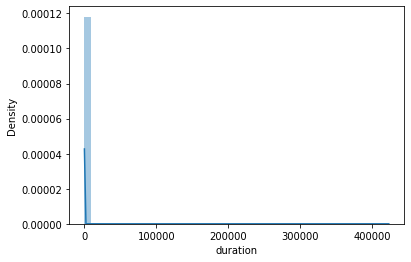

In [8]:
sns.distplot(data.duration)
plt.show()

In [9]:
data.describe()

,PUlocationID,DOlocationID,duration
count,195845.000000,991892.000000,1.154112e+06
mean,139.859690,135.898030,1.916722e+01
std,74.991382,80.474902,3.986922e+02
min,1.000000,1.000000,1.666667e-02
25%,75.000000,67.000000,7.766667e+00
50%,143.000000,132.000000,1.340000e+01
75%,206.000000,213.000000,2.228333e+01
max,265.000000,265.000000,4.233710e+05


In [10]:
# records (outliers) to drop
len(data) - len(data[(60.0 >= data.duration) & (data.duration >= 1.0)])

44286

In [11]:
data = data[(60.0 >= data.duration) & (data.duration >= 1.0)]

In [12]:
# fraction of missing values for pick up location ID
print((data["PUlocationID"].isnull().sum()/len(data["PUlocationID"]))*100,"%")

83.52732770722618 %


In [13]:
# filling missing values with "-1"
data[["PUlocationID","DOlocationID"]] = data[["PUlocationID","DOlocationID"]].fillna("-1")

In [14]:
data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1,-1,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1,-1,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1,71.0,None,B00037,9.050000


# Training model

In [15]:
# Creating one hot encoding
features = ["PUlocationID","DOlocationID"]
target = "duration"

In [16]:
data[features] = data[features].astype(str)

In [17]:
train_dicts = data[features].to_dict(orient="records")

In [18]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [19]:
#Dimensioality after OHE
len(dv.feature_names_)

525

In [20]:
y_train = data[target].values

In [21]:
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = lr.predict(X_train)

In [24]:
#RMSE on train
mean_squared_error(y_train, y_pred, squared = False)

10.528519107210744

#Model evaluation

In [25]:
eval_data = pd.read_parquet("https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet")

In [26]:
#cleanning
eval_data["duration"] = pd.to_datetime(eval_data["dropOff_datetime"]) - pd.to_datetime(eval_data["pickup_datetime"])
eval_data.duration = eval_data.duration.apply(lambda x: x.total_seconds() / 60)
eval_data = eval_data[(60.0 >= eval_data.duration) & (eval_data.duration >= 1.0)]
eval_data[["PUlocationID","DOlocationID"]] = eval_data[["PUlocationID","DOlocationID"]].fillna("-1")

In [27]:
# Creating one hot encoding
features = ["PUlocationID","DOlocationID"]
target = "duration"
data[features] = data[features].astype(str)

In [28]:
eval_dicts = eval_data[features].to_dict(orient="records")

X_val = dv.transform(eval_dicts)

In [29]:
y_val = eval_data[target].values

In [30]:
y_pred_eval = lr.predict(X_val)

In [31]:
#RMSE on validation
mean_squared_error(y_val, y_pred_eval, squared = False)

11.828385286105636